In [1]:
%pylab inline
import pandas as pd
import sklearn.ensemble as sk_ensemble
import sklearn.cross_validation as sk_cv
import xgboost as xgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
def rmsle(actual, predicted):
    error = np.log1p(predicted) - np.log1p(actual)
    return np.sqrt(np.mean(np.square(error)))

In [86]:
train = pd.read_csv('../preprocessed_train.csv')

In [87]:
train.head(10)

,tube_assembly_id,annual_usage,min_order_quantity,quantity,cost,year,supplier_S-0003,supplier_S-0004,supplier_S-0005,supplier_S-0006,...,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER,tube_volume
0,TA-00002,0,0,1,21.905933,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
1,TA-00002,0,0,2,12.341214,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
2,TA-00002,0,0,5,6.601826,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
3,TA-00002,0,0,10,4.687770,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
4,TA-00002,0,0,25,3.541561,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
5,TA-00002,0,0,50,3.224406,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
6,TA-00002,0,0,100,3.082521,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
7,TA-00002,0,0,250,2.999060,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
8,TA-00004,0,0,1,21.972702,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743
9,TA-00004,0,0,2,12.407983,2013,0,0,0,0,...,0,0,0,0,0,0,2,0,0,17137.76743


In [10]:
bracket_pricing_ta_ids = train[train.bracket_pricing_Yes == 1].tube_assembly_id.unique()
non_bracket_pricing_ta_ids = train[train.bracket_pricing_Yes != 1].tube_assembly_id.unique()

In [11]:
print bracket_pricing_ta_ids.shape
print non_bracket_pricing_ta_ids.shape

(4925,)
(3930,)


In [88]:
print train[train.bracket_pricing_Yes == 1].shape
print train[train.bracket_pricing_Yes != 1].shape

(26283, 262)
(3930, 262)


In [13]:
bp_ids_train_cv, bp_ids_test = \
sk_cv.train_test_split(bracket_pricing_ta_ids, train_size = 0.7, random_state = 0)

In [23]:
print bp_ids_train_cv.shape
print bp_ids_test.shape
print type(bp_ids_train_cv)

(3447,)
(1478,)
<type 'numpy.ndarray'>


In [14]:
nbp_ids_train_cv, nbp_ids_test = \
sk_cv.train_test_split(non_bracket_pricing_ta_ids, train_size = 0.7, random_state = 0)

In [26]:
train_cv = train.ix[train.tube_assembly_id.isin(bp_ids_train_cv.tolist() + nbp_ids_train_cv.tolist()), ]
holdout = train.ix[train.tube_assembly_id.isin(bp_ids_test.tolist() + nbp_ids_test.tolist()), ]

In [27]:
print train_cv.shape
print holdout.shape

(21148, 262)
(9065, 262)


In [70]:
kfold_bp = sk_cv.KFold(bracket_pricing_ta_ids.shape[0], 10, shuffle=True, random_state=0)
kfold_nbp = sk_cv.KFold(non_bracket_pricing_ta_ids.shape[0], 10, shuffle=True, random_state=0)

In [95]:
# print kfold_bp
# print kfold_nbp

In [96]:
for train_kf, test_kf in kfold_bp:
    ta_ids_in_train = bracket_pricing_ta_ids[train_kf, ].tolist()
    ta_ids_in_cv = bracket_pricing_ta_ids[test_kf, ].tolist()
    train_df = train.ix[train.tube_assembly_id.isin(ta_ids_in_train), ]
    cv_df = train.ix[train.tube_assembly_id.isin(ta_ids_in_cv), ]
    X = train_df.drop(['tube_assembly_id', 'cost'], axis=1).values
    y = train_df.cost
    rf = sk_ensemble.RandomForestRegressor(n_estimators=50, n_jobs=4, oob_score=True)
    rf = rf.fit(X, np.log1p(y))
    holdout_X = cv_df.drop(['tube_assembly_id', 'cost'], axis=1).values
    holdout_y = cv_df.cost
    holdout_y_fitted = np.expm1(rf.predict(holdout_X))
    print rmsle(holdout_y, holdout_y_fitted)

0.213270124344
0.206985965468
0.219897603121
0.214946107211
0.247947453011
0.269300904528
0.241961392971
0.205275566031
0.26333088792
0.220273870158


In [100]:
for train_kf, test_kf in kfold_nbp:
    ta_ids_in_train = non_bracket_pricing_ta_ids[train_kf, ].tolist()
    ta_ids_in_cv = non_bracket_pricing_ta_ids[test_kf, ].tolist()
    train_df = train.ix[train.tube_assembly_id.isin(ta_ids_in_train), ]
    cv_df = train.ix[train.tube_assembly_id.isin(ta_ids_in_cv), ]
    X = train_df.drop(['tube_assembly_id', 'cost'], axis=1).values
    y = train_df.cost
    rf = sk_ensemble.RandomForestRegressor(n_estimators=250, n_jobs=4, oob_score=True)
    rf = rf.fit(X, np.log1p(y))
    
    y_fitted = np.expm1(rf.predict(X))
    print 'in sample: %f.2' % rmsle(y_fitted, y)
    
    holdout_X = cv_df.drop(['tube_assembly_id', 'cost'], axis=1).values
    holdout_y = cv_df.cost
    holdout_y_fitted = np.expm1(rf.predict(holdout_X))
    print 'cv: %f.2' %rmsle(holdout_y, holdout_y_fitted)

in sample: 0.176850.2
cv: 0.414874.2
in sample: 0.175543.2
cv: 0.488300.2
in sample: 0.175455.2
cv: 0.450108.2
in sample: 0.174941.2
cv: 0.493398.2
in sample: 0.174167.2
cv: 0.470541.2
in sample: 0.174378.2
cv: 0.468248.2
in sample: 0.175458.2
cv: 0.497801.2
in sample: 0.175697.2
cv: 0.483645.2
in sample: 0.175023.2
cv: 0.474844.2
in sample: 0.174496.2
cv: 0.471503.2


In [68]:
# train_sub_train, train_sub_cv = sk_cv.train_test_split(train.ix[:29000], train_size = 0.5, random_state = 346)
# train_sub_test = train.ix[29000:]

In [54]:
X = train_cv.drop(['tube_assembly_id', 'cost'], axis=1).values
y = train_cv.cost
# , random_state=0, verbose=0
rf = sk_ensemble.RandomForestRegressor(n_estimators=250, n_jobs=4, oob_score=True)
rf = rf.fit(X, np.log1p(y))

In [57]:
y_fitted = np.expm1(rf.predict(X))
print rmsle(y, y_fitted)

0.0878637867054


In [55]:
holdout_X = holdout.drop(['tube_assembly_id', 'cost'], axis=1).values
holdout_y = holdout.cost

holdout_y_fitted = np.expm1(rf.predict(holdout_X))

In [56]:
print rmsle(holdout_y, holdout_y_fitted)

0.257597644825


In [38]:
feats_imp = pd.DataFrame({'feats' : train_cv.drop(['tube_assembly_id', 'cost'], axis=1).columns, \
                         'imp' : rf.feature_importances_})

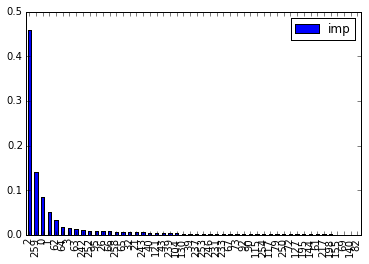

In [94]:
feats_imp.sort(columns=['imp'], ascending=False).head(50).plot(kind='bar')

In [82]:
X_cv = train_sub_cv.drop(['tube_assembly_id', 'quote_date', 'cost'], axis=1).values
y_cv = train_sub_cv.cost
X_test = train_sub_test.drop(['tube_assembly_id', 'quote_date', 'cost'], axis=1).values
y_test = train_sub_test.cost
y_cv_fitted = np.expm1(rf.predict(X_cv))

In [83]:
print rmsle(y_cv, y_cv_fitted)
print y_cv[:10]
print y_cv_fitted[:10]

0.248358061663
8768      4.657167
17279    21.115828
11098     7.578329
13415    13.033947
26622    11.843225
23383     8.696717
25047     6.754839
28684     1.986390
26369    21.892023
22634    18.687091
Name: cost, dtype: float64
[  4.78016727  22.18499406   7.70401672  13.63151068  11.24795093
  10.80556044   6.64042232   2.15777853  21.26286314  15.32715093]


In [73]:
kaggle_test_df.head()

,annual_usage,cost,min_order_quantity,quantity,quantity_rep,quote_date,tube_assembly_id,year,supplier_S-0003,supplier_S-0004,...,CP-022,CP-023,CP-024,CP-025,CP-026,CP-027,CP-028,CP-029,OTHER,tube_volume
0,0,0,0,1,1.00,2013-06-23,TA-00001,2013,0,0,...,0,0,0.024,0.072,0,0,0,0,0,81697.336868
1,0,0,0,2,0.50,2013-06-23,TA-00001,2013,0,0,...,0,0,0.024,0.072,0,0,0,0,0,81697.336868
2,0,0,0,5,0.20,2013-06-23,TA-00001,2013,0,0,...,0,0,0.024,0.072,0,0,0,0,0,81697.336868
3,0,0,0,10,0.10,2013-06-23,TA-00001,2013,0,0,...,0,0,0.024,0.072,0,0,0,0,0,81697.336868
4,0,0,0,25,0.04,2013-06-23,TA-00001,2013,0,0,...,0,0,0.024,0.072,0,0,0,0,0,81697.336868


In [84]:
kaggle_test = pd.read_csv('../test_dummies_adjusted.csv')
kaggle_test_df = pd.merge(kaggle_test, tube)
kaggle_test_df = pd.merge(kaggle_test_df, spec)
kaggle_test_df = pd.merge(kaggle_test_df, comp_type_weight)
kaggle_test_df = pd.merge(kaggle_test_df, tube_vol)
kaggle_test_vals = kaggle_test_df.drop(['tube_assembly_id', 'quote_date', 'cost', 'id'], axis=1).values
preds = np.expm1(rf.predict(kaggle_test_vals))

In [85]:
preds[:10]

array([ 28.62403488,  24.8836941 ,  20.91606194,  10.27019523,
         8.71596676,   8.64892847,   8.61588627,   8.59260788,
        28.59496226,  20.44210586])